In [1]:
import os
import shutil

def discard_unfinished_reports(CONSENUS):
    reports_dir = 'reports'
    test_configs =[os.path.join(reports_dir,d) for d in os.listdir(reports_dir) if os.path.isdir(os.path.join(reports_dir,d)) and d.startswith(CONSENUS)]
    for test_config in test_configs:
        for i in range(1,6):
            path=test_config+f'/{i}'
            if os.path.isdir(path):
                if not is_finished(path+'/report.html'):
                    shutil.rmtree(path)
        finished_reports = [os.path.join(test_config,d) for d in os.listdir(test_config) if os.path.isdir(os.path.join(test_config,d))]
        if len(finished_reports) > 0:
            if os.path.isdir(finished_reports[0]):
                shutil.copytree(finished_reports[0],test_config,dirs_exist_ok=True)
            for f in finished_reports:
                shutil.rmtree(f)
    print('Reports Ready to be ananlyzed and plotted')



def is_finished(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    start_marker = '<table'
    end_marker = '</table>'
    start_index = html_content.find(start_marker)
    end_index = html_content.find(end_marker, start_index)
    table_content = html_content[start_index:end_index + len(end_marker)]
    rows = table_content.split('</tr>')
    for row in rows[1:len(rows)-1]:
        cells = row.split('</td>')
        fail_value = cells[2].split('>')[-1].strip()
        if int(fail_value) != 0:
            return False
    return True

discard_unfinished_reports('QBFT')

Reports Ready to be ananlyzed and plotted


In [2]:
from html.parser import HTMLParser
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_report_stats(CONFIG):
    html_file_path = os.path.join('reports',CONFIG,'report.html')
    tables = pd.read_html(html_file_path)
    config_vars=CONFIG.split('_')
    stat_row=[]
    stat_row.append(int(config_vars[1]))
    stat_row.append(int(config_vars[2]))
    #round open
    arr=get_from_tables(tables[1].to_numpy(),tables[2].to_numpy())
    stat_row.append(arr)
    #round query
    arr=get_from_tables(tables[3].to_numpy(),tables[4].to_numpy())
    stat_row.append(arr)
    #round transfer
    arr=get_from_tables(tables[5].to_numpy(),tables[6].to_numpy())
    stat_row.append(arr)
    return stat_row

def get_from_tables(tablem,tabler):
    arr=[]
    arr.append(tablem[0][4])
    arr.append(tablem[0][6])
    arr.append(tablem[0][7])

    cmm=0
    cam=0
    mmm=0
    mam=0
    for r in tabler:
        if r[1] > cmm:
            cmm=r[1]
        if r[2] > cam:
            cam=r[2]
        if r[3] > mmm:
            mmm=r[3]
        if r[4] > mam:
            mam=r[4]
    arr.append(cmm)
    arr.append(cam)
    arr.append(mmm)
    arr.append(mam)
    return arr

def get_consensus_stats(CONSENSUS):
    con_arr=[]
    configs =[d for d in os.listdir('reports') if os.path.isdir(os.path.join('reports',d)) and d.startswith(CONSENSUS)]
    for config in configs:
        arr=get_report_stats(config)
        con_arr.append(arr)
    with open(f'{CONSENSUS}_array.pkl','wb') as file:
        pickle.dump(con_arr,file)


get_consensus_stats('QBFT')

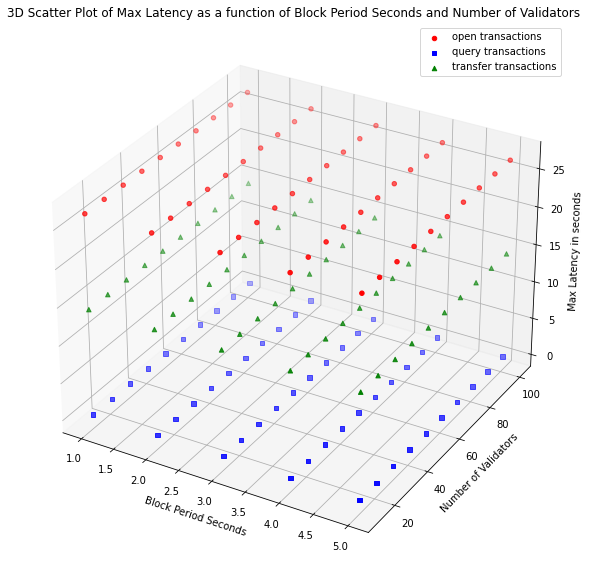

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


def plot(CONSENSUS,INDEX,SAVE_TITLE):
    with open(f'{CONSENSUS}_array.pkl', 'rb') as file:
        data = pickle.load(file)

    # Extract x, y, and parameter values from the data
    x_values = [row[1] for row in data]
    y_values = [row[0] for row in data]
    oml_values = [row[2][INDEX] for row in data]
    qml_values = [row[3][INDEX] for row in data]
    tml_values = [row[4][INDEX] for row in data]

    # Convert x, y, and parameter values to NumPy arrays
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    oml_values = np.array(oml_values)
    qml_values = np.array(qml_values)
    tml_values = np.array(tml_values)

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points for oml, qml, and tml
    ax.scatter(x_values, y_values, oml_values, c='r', marker='o', label='open transactions')
    ax.scatter(x_values, y_values, qml_values, c='b', marker='s', label='query transactions')
    ax.scatter(x_values, y_values, tml_values, c='g', marker='^', label='transfer transactions')

    # ax.plot(x_values, y_values, oml_values, c='r', linestyle='dotted', label='open transactions')
    # ax.plot(x_values, y_values, qml_values, c='b', linestyle='dotted', label='query transactions')
    # ax.plot(x_values, y_values, tml_values, c='g', linestyle='dotted', label='transfer transactions')

    # Set labels and title
    if CONSENSUS=='ETHASH':
        ax.set_xlabel('Fixed Difficulity')
    else:
        ax.set_xlabel('Block Period Seconds')

    ax.set_ylabel('Number of Validators')
    match INDEX:
        case 0:
            ax.set_zlabel('Max Latency in seconds')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        case 1:
            ax.set_zlabel('Average Latency in seconds')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        case 2:
            ax.set_zlabel('Throughput in Tx/s')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        case 3:
            ax.set_zlabel('Max CPU Utilization')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        case 4:
            ax.set_zlabel('Average CPU Utilization')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        case 5:
            ax.set_zlabel('Max Memory Utilization in MB')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        case 6:
            ax.set_zlabel('Average Memory Utilization in MB')
            ax.set_title('3D Scatter Plot of Parameters as a function of x and y')
        case '_':
            ax.setzlabel('value')
            if CONSENSUS=='ETHASH':
                ax.set_title('3D Scatter Plot of Max Latency as a function of Fixed Difficulity and Number of Validators')
            else:
                ax.set_title('3D Scatter Plot of Max Latency as a function of Block Period Seconds and Number of Validators')
        

    # Add a legend
    ax.legend()

    # Save the plot as a PNG image file
    plt.savefig(f'figs/{SAVE_TITLE}.png')

    # Save the plot as a PDF file
    plt.savefig(f'figs/{SAVE_TITLE}.pdf', format='pdf')

    # Show the plot
    plt.show()


plot('QBFT', 0 ,'QBFT ml')
# plot('QBFT', 1 ,'QBFT al')
# plot('QBFT', 2 ,'QBFT tps')
# plot('QBFT', 3 ,'QBFT cm')
# plot('QBFT', 4,'QBFT ca')
# plot('QBFT', 5 ,'QBFT mm')
# plot('QBFT', 6 ,' QBFT am')

# plot('IBFT', 0 ,'IBFT ml')
# plot('IBFT', 1 ,'IBFT al')
# plot('IBFT', 2 ,'IBFT tps')
# plot('IBFT', 3 ,'IBFT cm')
# plot('IBFT', 4,'IBFT ca')
# plot('IBFT', 5 ,'IBFT mm')
# plot('IBFT', 6 ,' IBFT am')

# plot('CLIQUE', 0 ,'CLIQUE ml')
# plot('CLIQUE', 1 ,'CLIQUE al')
# plot('CLIQUE', 2 ,'CLIQUE tps')
# plot('CLIQUE', 3 ,'CLIQUE cm')
# plot('CLIQUE', 4,'CLIQUE ca')
# plot('CLIQUE', 5 ,'CLIQUE mm')
# plot('CLIQUE', 6 ,' CLIQUE am')

# plot('ETHASH', 0 ,'ETHASH ml')
# plot('ETHASH', 1 ,'ETHASH al')
# plot('ETHASH', 2 ,'ETHASH tps')
# plot('ETHASH', 3 ,'ETHASH cm')
# plot('ETHASH', 4,'ETHASH ca')
# plot('ETHASH', 5 ,'ETHASH mm')
# plot('ETHASH', 6 ,' ETHASH am')
